In [1]:
%reload_ext autoreload
%autoreload 2
from scrape_GR_tools import *
from scrape_explore import *
from friend_groups import *
from modeling import *
#put this in scrape_GR_tools
import pandas as pd

import graphlab as gl
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 36)

import networkx as nx
import nxpd as nxpd
from IPython.display import display, Image
import community

from datetime import date, datetime
grDateFormat = '%b %d, %Y'

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors

from itertools import product
from collections import defaultdict

This non-commercial license of GraphLab Create for academic use is assigned to ref302@nyu.edu and will expire on October 13, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1492194407.log


SETTING UP DATA FOR PREDICTION

In [5]:
mongoClientName = "mongodb://54.70.37.60" # replace XXX with the location of your mongo client
# here I used one of my Amazon EC2 instances and its associated storage as a central location for MongoDB
client = MongoClient(mongoClientName)

In [6]:
allComms = collectAllComms(client)

Checking database 'goodreads_explore_from_book_tnc'
Database has 0 comms (we now have 0 in total)

Checking database 'goodreads_explore_from_book_ender'
Database has 11 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_fault_in_our_stars'
Database has 0 comms (we now have 11 in total)

Checking database 'goodreads_explore_from_book_hedgehog'
Database has 2 comms (we now have 13 in total)

Checking database 'goodreads_explore_from_book_pride_and_prejudice'
Database has 9 comms (we now have 22 in total)

Checking database 'goodreads_explore_from_book_mice_and_men'
Database has 11 comms (we now have 33 in total)

Checking database 'goodreads_explore_from_book_jest'
Database has 19 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_swiftly'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_from_book_floornight'
Database has 0 comms (we now have 52 in total)

Checking database 'goodreads_explore_fr

In [7]:
dbFull = client['goodreads_full']

ratingsFull = dbFull['ratings']
friendsFull = dbFull['friends']
booksFull = dbFull['books']

#updateCommsOfRaters2(booksFull, allComms)
#updateCommsOfRaters(ratingsFull, booksFull, allComms)
booksToRaterComms = getCommsOfRaters(ratingsFull, allComms)

In [8]:
glRatings = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 7, 25, False)
outlierDict, glRatingsNoOutliers = removeGlOutliers(glRatings)

In [ ]:
#glRatingsSecondPass = glRatings[glRatings['']]
#numRatingsByUser = glRatings.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')}).to_dataframe()
#numRatingsByUser_df=numRatingsByUser.set_index('userID')
#numRatingsByUser_df.loc[glRatings['userID']]['numRatings']>20
#glRatings.filter_by?

In [ ]:
trainSplitRmses = []
trainSplitRmsesFake = []

In [9]:
glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID",
                                                    max_num_users=None,
                                                    item_test_proportion=0.1)
'''

glRatingsTrain, glRatingsTest = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20,\
                                                     True, datetime.strptime('Apr 17, 2013', grDateFormat))

glRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]
glRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]
'''

"\n\nglRatingsTrain, glRatingsTest = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 20, 20,                                                     True, datetime.strptime('Apr 17, 2013', grDateFormat))\n\nglRatingsTrain = glRatingsTrain[glRatingsTrain['comm'].apply(lambda x: outlierDict[x])]\nglRatingsTest = glRatingsTest[glRatingsTest['comm'].apply(lambda x: outlierDict[x])]\n"

In [25]:
# EDA comparing movielens to GR
# loading data

header = ['user_id', 'item_id', 'rating', 'timestamp']
df_ml = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df_ml = df_ml.rename(columns={'user_id':'userID','item_id':'bookID'})

df_gr = makeRecommenderInputs(ratingsFull, booksFull, allComms, booksToRaterComms, 7, 25, False).to_dataframe()

In [26]:
# EDA comparing movielens to GR

df_ml_users = df_ml.groupby(['userID'])['rating'].count()
print 'movielens: ratings per user stats\n'
print df_ml_users.describe()

print '\n\ngoodreads: ratings per user stats\n'
df_gr_users = df_gr.groupby(['userID'])['rating'].count()
print df_gr_users.describe()

df_ml_items = df_ml.groupby(['bookID'])['rating'].count()
print '\n\nmovielens: ratings per item stats\n'
print df_ml_items.describe()

print '\n\ngoodreads: ratings per item stats\n'
df_gr_items = df_gr.groupby(['bookID'])['rating'].count()
print df_gr_items.describe()

movielens: ratings per user stats

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64


goodreads: ratings per user stats

count    1154.000000
mean       81.599653
std        59.714390
min        19.000000
25%        39.000000
50%        64.000000
75%       104.000000
max       445.000000
Name: rating, dtype: float64


movielens: ratings per item stats

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64


goodreads: ratings per item stats

count    1826.000000
mean       51.569551
std        67.673647
min         7.000000
25%        11.000000
50%        29.000000
75%        63.750000
max       662.000000
Name: rating, dtype: float64


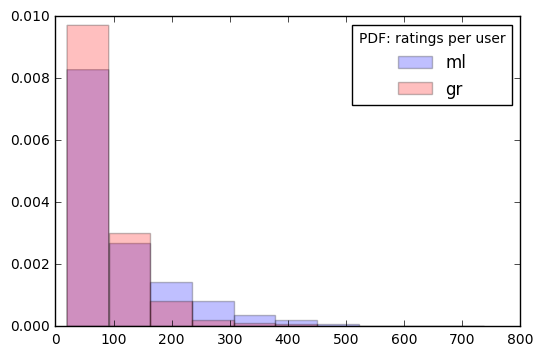

In [11]:
histStuff= plt.hist(df_ml_users,alpha=0.25,normed=True,label='ml');
plt.hist(df_gr_users,alpha=0.25,bins=histStuff[1],normed=True,color='r',label='gr');
plt.legend(title='PDF: ratings per user');

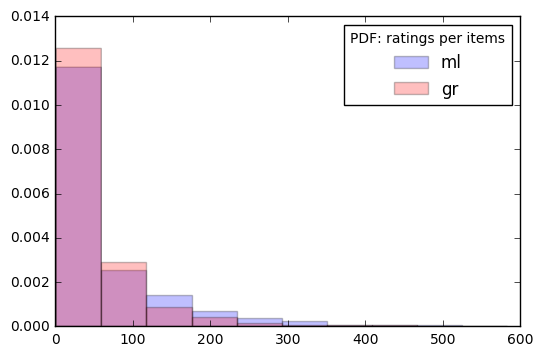

In [12]:
histStuff= plt.hist(df_ml_items,alpha=0.25,normed=True,label='ml');
plt.hist(df_gr_items,alpha=0.25,bins=histStuff[1],normed=True,color='r',label='gr');
plt.legend(title='PDF: ratings per items');

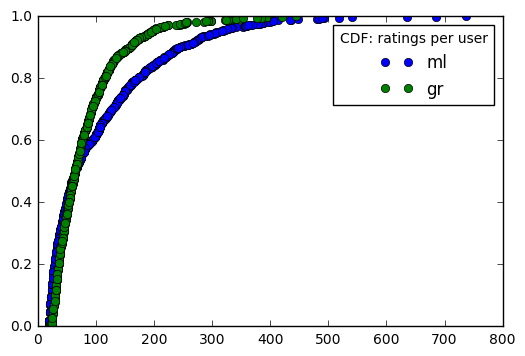

In [13]:
plt.plot(df_ml_users,df_ml_users.rank()/len(df_ml_users.rank()),'o',label='ml');
plt.plot(df_gr_users,df_gr_users.rank()/len(df_gr_users.rank()),'o',label='gr');
plt.legend(title='CDF: ratings per user');

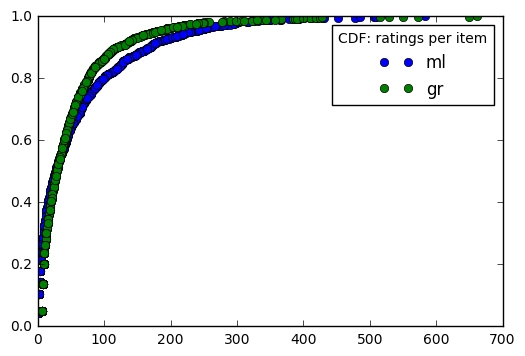

In [14]:
plt.plot(df_ml_items,df_ml_items.rank()/len(df_ml_items.rank()),'o',label='ml');
plt.plot(df_gr_items,df_gr_items.rank()/len(df_gr_items.rank()),'o',label='gr');
plt.legend(title='CDF: ratings per item');

In [99]:
# testing on movielens

header = ['user_id', 'item_id', 'rating', 'timestamp']
df_ml = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df_ml = df_ml.rename(columns={'user_id':'userID','item_id':'bookID'})

glRatings = gl.SFrame(df_ml)

glRatingsTrain, glRatingsTest = gl.recommender.util.random_split_by_user(glRatings, 
                                                    user_id="userID", 
                                                    item_id="bookID",
                                                    max_num_users=None,
                                                    item_test_proportion=0.1)
                                                    

In [11]:
# removing intercept and user/book means

intercept = glRatingsTrain['rating'].mean()

glRatingsTrain['rating'] = glRatingsTrain['rating'] - intercept

userMeans = glRatingsTrain.groupby(['userID'],{'userMeans': gl.aggregate.AVG('rating')})
bookMeans = glRatingsTrain.groupby(['bookID'],{'bookMeans': gl.aggregate.AVG('rating')})

userMeansDict = defaultdict(float,{u['userID']:u['userMeans'] for u in userMeans})
bookMeansDict = defaultdict(float,{b['bookID']:b['bookMeans'] for b in bookMeans})

userShiftsTrain = glRatingsTrain.apply(lambda x: userMeansDict[x['userID']])
bookShiftsTrain = glRatingsTrain.apply(lambda x: bookMeansDict[x['bookID']])

glRatingsTrain['rating'] = glRatingsTrain['rating'] - userShiftsTrain - bookShiftsTrain

In [12]:
# removing intercept and user/book means

# removing train means from test here is not data leakage -- it's a hack to mimic a recommender that memorizes
# the means from the training data and uses them to predict
# (to get around the fact that graphlab's recommenders can't use ALS optimization with linear/intercept terms)

glRatingsTest['rating'] = glRatingsTest['rating'] - intercept

userShiftsTest = glRatingsTest.apply(lambda x: userMeansDict[x['userID']])
bookShiftsTest = glRatingsTest.apply(lambda x: bookMeansDict[x['bookID']])

glRatingsTest['rating'] = glRatingsTest['rating'] - userShiftsTest - bookShiftsTest

In [332]:
print glRatingsTrain.shape[0]
print glRatingsTest.shape[0]
print float(glRatingsTest.shape[0]) / (glRatingsTest.shape[0] + glRatingsTrain.shape[0])

90015
9985
0.09985


In [16]:
numRatingsByUser = glRatings.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByUser = pd.Series(numRatingsByUser)
numRatingsByUser.describe()
#(numRatingsByUser >= 20).mean()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
dtype: float64

In [17]:
numRatingsByBook = glRatings.groupby(['bookID'], {'numRatings': gl.aggregate.COUNT('rating')})['numRatings']
numRatingsByBook = pd.Series(numRatingsByBook)
(numRatingsByBook >= 20).mean()
numRatingsByBook.describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64

PREDICTION

TRADITIONAL RECOMMENDER

In [10]:
# make sure we train the recommender without community information

glRatingsTrainWithComm = glRatingsTrain.copy()
glRatingsTestWithComm = glRatingsTest.copy()

if 'comm' in glRatingsTrain.column_names():
    glRatingsTrain.remove_column('comm');
if 'comm' in glRatingsTest.column_names():
    glRatingsTest.remove_column('comm');

In [11]:
degreesOfFreedomStats(glRatingsTrain)

84717 observations
1154 users
1826 books

A recommender with 0 factor(s) (plus linear terms) would use 3.5% of the degrees of freedom present in the data.
(28.4 observations per model degree of freedom)

A recommender with 1 factor(s) (plus linear terms) would use 7.0% of the degrees of freedom present in the data.
(14.2 observations per model degree of freedom)

A recommender with 2 factor(s) (plus linear terms) would use 10.6% of the degrees of freedom present in the data.
(9.5 observations per model degree of freedom)

A recommender with 3 factor(s) (plus linear terms) would use 14.1% of the degrees of freedom present in the data.
(7.1 observations per model degree of freedom)

A recommender with 4 factor(s) (plus linear terms) would use 17.6% of the degrees of freedom present in the data.
(5.7 observations per model degree of freedom)

A recommender with 5 factor(s) (plus linear terms) would use 21.1% of the degrees of freedom present in the data.
(4.7 observations per model degree

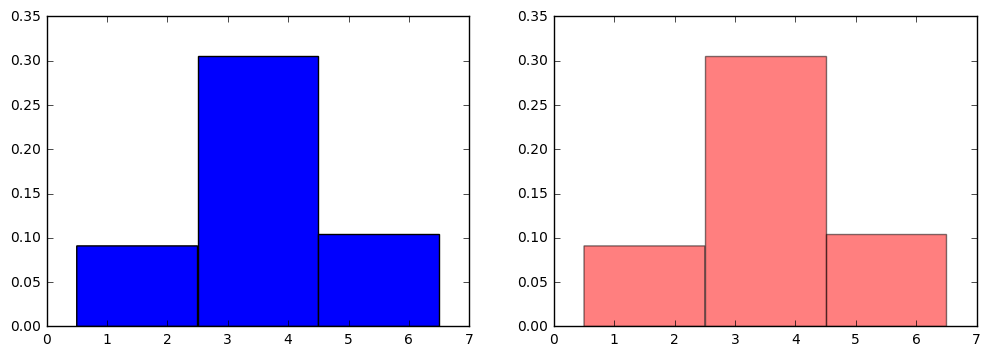

In [20]:

#TRANSFORMING TO UNIFORM DISTRIBUTION
rating_cats = range(1,6)
rating_counts = np.array([sum(np.array(glRatingsTrain['rating']) == rating) for rating in rating_cats])
transformed_ratings = 1 + np.cumsum(4*rating_counts/float(rating_counts.sum()))
transformed_rating_dict = dict(zip(rating_cats,transformed_ratings))
transformed_rating_dict_inv = {v:k for (k,v) in transformed_rating_dict.items()}

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(glRatingsTest['rating'],normed=True,alpha=1,bins=[0.5,2.5,4.5,6.5]);
plt.subplot(122)
plt.hist(glRatingsTest['rating'].apply(lambda x: transformed_rating_dict[x]),normed=True,alpha=0.5,color='r',\
        bins=[0.5,2.5,4.5,6.5]);

In [263]:
#the two lines below scale to uniform dist
#glRatingsTrain['rating'] = glRatingsTrain['rating'].apply(lambda x: transformed_rating_dict[x])
#glRatingsTest['rating'] = glRatingsTest['rating'].apply(lambda x: transformed_rating_dict[x])

In [315]:

models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'solver': 'adagrad',
                                                      'sgd_step_size':  [0.03, 0.01],
                                                      'num_factors': [5,10,20,40],
                                                      'max_iterations': 100,
                                                      'regularization': reg_array,
                                                      'linear_regularization': [1e-10],
                                                      },
                                                      perform_trial_run=False
                                                      )
'''
models = gl.toolkits.model_parameter_search.grid_search.create((glRatingsTrain, glRatingsTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'userID',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': 0,
                                                      'max_iterations': 2000,
                                                      'regularization': 1e-3,
                                                      'linear_regularization': [10**i for i in range(-4,0)]
                                                      })
'''

SyntaxError: invalid syntax (<ipython-input-315-14119efc939c>, line 9)

In [268]:
#models.get_status()
#models.cancel()
models.get_results().sort('validation_rmse')

Columns:
	model_id	int
	item_id	str
	linear_regularization	float
	max_iterations	int
	num_factors	int
	regularization	float
	solver	str
	target	str
	user_id	str
	training_precision@5	float
	training_recall@5	float
	training_rmse	float
	validation_precision@5	float
	validation_recall@5	float
	validation_rmse	float

Rows: 6

Data:
+----------+---------+-----------------------+----------------+-------------+
| model_id | item_id | linear_regularization | max_iterations | num_factors |
+----------+---------+-----------------------+----------------+-------------+
|    2     |  bookID |         1e-10         |      100       |      1      |
|    4     |  bookID |         1e-10         |      100       |      1      |
|    3     |  bookID |         1e-10         |      100       |      2      |
|    5     |  bookID |         1e-10         |      100       |      2      |
|    1     |  bookID |         1e-10         |      100       |      2      |
|    0     |  bookID |         1e-10         |      100       |      1      |
+----------+---------+-----------------------+----------------+-------------+
+----------------+--------+--------+---------+----------------------+
| regularization | solver | target | user_id | training_precision@5 |
+----------------+--------+--------+---------+----------------------+
|     0.0001     |  sgd   | rating |  userID |   0.0124783362218    |
|     5e-05      |  sgd   | rating |  userID |   0.00693240901213   |
|     0.0001     |  sgd   | rating |  userID |   0.0180242634315    |
|     5e-05      |  sgd   | rating |  userID |   0.0103986135182    |
|     0.005      |  sgd   | rating |  userID |   0.0658578856153    |
|     0.005      |  sgd   | rating |  userID |   0.0658578856153    |
+----------------+--------+--------+---------+----------------------+
+-------------------+----------------+------------------------+
| training_recall@5 | training_rmse  | validation_precision@5 |
+-------------------+----------------+------------------------+
| 0.000720201131958 | 0.816356018306 |         0.0034         |
| 0.000482963769555 | 0.811840472836 |         0.002          |
|  0.00100685548973 | 0.789775310228 |         0.0042         |
| 0.000795488810144 | 0.782283890719 |         0.0042         |
|  0.00445835968277 | 0.873117341044 |         0.0218         |
|  0.00445835968277 | 0.873109410456 |         0.0212         |
+-------------------+----------------+------------------------+
+---------------------+-----------------+
| validation_recall@5 | validation_rmse |
+---------------------+-----------------+
|   0.00108564972894  |  0.884693660096 |
|  0.000880903214433  |  0.887145087934 |
|   0.00119645160912  |  0.890168594334 |
|   0.0013386538428   |  0.899435484145 |
|   0.00598435781233  |  0.901348094457 |
|   0.00589813202908  |  0.901370459921 |
+---------------------+-----------------+
[6 rows x 15 columns]

In [ ]:
'''
test=models.get_models()[3].get('coefficients')['bookID']
factors=[row['factors'][0]  for row in test]
test2=test.to_dataframe().ix[np.argsort(factors)]

for i in range(10):
    bID = test2.iloc[i]['bookID']
    print bookTitle(bID)
    
print '\n'

for i in range(10):
    bID = test2[::-1].iloc[i]['bookID']
    print bookTitle(bID)
    '''

In [105]:
rec_engine_baseline = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='sgd',
                                                    max_iterations=50,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-10,
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 90015 observations with 943 users and 1662 items.

Data prepared in: 0.186388s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-10    |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11251 / 90015 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.818226          | 0.997516                                 |

| 1       | 0.409113          | 0.890052                                 |

| 2       | 0.204556          | 0.766723                                 |

| 3       | 0.102278          | 0.732738                                 |

| 4       | 0.0511391         | 0.756788                                 |

| 5       | 0.0255695         | 0.799368                                 |

| 6       | 0.0127848         | 0.84887                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.102278          | 0.732738                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 77us         | 1.26529           | 1.12485               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 588.911ms    | 1.08389           | 1.0411                | 0.102278    |

| 2       | 1.16s        | 0.907912          | 0.952843              | 0.0100208   |

| 3       | 1.72s        | 0.856969          | 0.925726              | 0.0052685   |

| 4       | 2.32s        | 0.848851          | 0.921331              | 0.0035737   |

| 5       | 2.89s        | 0.844839          | 0.919151              | 0.00270389  |

| 6       | 3.47s        | 0.842984          | 0.918141              | 0.00217461  |

| 10      | 6.08s        | 0.838984          | 0.915961              | 0.00121964  |

| 11      | 6.66s        | 0.838438          | 0.915663              | 0.00109899  |

| 15      | 8.88s        | 0.837179          | 0.914975              | 0.000787409 |

| 20      | 11.75s       | 0.836253          | 0.914469              | 0.000581374 |

| 25      | 14.65s       | 0.835726          | 0.914181              | 0.0004608   |

| 30      | 17.59s       | 0.835352          | 0.913976              | 0.000381648 |

| 35      | 20.43s       | 0.835081          | 0.913828              | 0.000325702 |

| 40      | 23.31s       | 0.834871          | 0.913713              | 0.000284062 |

| 45      | 26.19s       | 0.834708          | 0.913624              | 0.000251861 |

| 50      | 29.03s       | 0.834578          | 0.913552              | 0.000226218 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.833831

Final training RMSE: 0.913143

In [108]:
print rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.941148950658


In [109]:
rec_engine = gl.factorization_recommender.create(   observation_data=glRatingsTrain, 
                                                    user_id="userID", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=4,
                                                    solver='sgd',
                                                    max_iterations=50,
                                                    regularization = (1e-2)/(glRatingsTrain.shape[0]),
                                                    linear_regularization = (1e-2)/glRatingsTrain.shape[0],
                                                    random_seed=np.random.randint(1e5),
                                                 sgd_sampling_block_size=2
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 90015 observations with 943 users and 1662 items.

Data prepared in: 0.15236s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 1.11e-07 |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1.11e-07 |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 11251 / 90015 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | 0.733349                                 |

| 4       | 0.195312          | 0.679752                                 |

| 5       | 0.0976562         | 0.703992                                 |

| 6       | 0.0488281         | 0.727518                                 |

| 7       | 0.0244141         | 0.775407                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.195312          | 0.679752                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 72us         | 1.26526           | 1.12484               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 555.257ms    | 2.50414           | 1.58221               | 0.195312    |

| 2       | 1.14s        | 1.37692           | 1.17326               | 0.116134    |

| 3       | 1.69s        | 1.07522           | 1.03678               | 0.0856819   |

| 4       | 2.26s        | 0.929805          | 0.9641                | 0.0580668   |

| 5       | 2.84s        | 0.862547          | 0.928556              | 0.0491185   |

| 6       | 3.43s        | 0.828822          | 0.910207              | 0.042841    |

| 10      | 5.74s        | 0.753066          | 0.867567              | 0.029206    |

| 11      | 6.29s        | 0.742004          | 0.861164              | 0.0271912   |

| 15      | 8.86s        | 0.712893          | 0.844078              | 0.0215479   |

| 20      | 11.68s       | 0.690827          | 0.830888              | 0.017366    |

| 25      | 14.56s       | 0.6782            | 0.823243              | 0.0146899   |

| 30      | 17.37s       | 0.668075          | 0.817061              | 0.0128124   |

| 35      | 20.25s       | 0.66114           | 0.812799              | 0.0114136   |

| 40      | 23.11s       | 0.655727          | 0.809456              | 0.0103259   |

| 45      | 25.99s       | 0.641286          | 0.800481              | 0.00668418  |

| 50      | 28.92s       | 0.63372           | 0.795737              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.612922

Final training RMSE: 0.782559

In [110]:
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']
#print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - np.array(glRatingsTest['rating']).std()
print rec_engine.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall'] - rec_engine_baseline.evaluate_rmse(glRatingsTest, target='rating')['rmse_overall']

0.963337992241
0.0221890415834


In [101]:
file_path_train='gl_ml_train'
file_path_test='gl_ml_test'

#glRatingsTrain['userID','bookID','rating'].export_csv(file_path_train,header=True,delimiter='\t')
#glRatingsTest['userID','bookID','rating'].export_csv(file_path_test,header=True,delimiter='\t')

glRatingsTrain = gl.SFrame.read_csv(file_path_train,header=True,delimiter='\t')
glRatingsTest = gl.SFrame.read_csv(file_path_test,header=True,delimiter='\t')

Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_ml_train

Parsing completed. Parsed 100 lines in 0.035615 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_ml_train

Parsing completed. Parsed 90015 lines in 0.04626 secs.

Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_ml_test

Parsing completed. Parsed 100 lines in 0.016633 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_ml_test

Parsing completed. Parsed 9985 lines in 0.019575 secs.

In [12]:
file_path_train='gl_gr_train'
file_path_test='gl_gr_test'

#glRatingsTrain['userID','bookID','rating'].export_csv(file_path_train,header=True,delimiter='\t')
#glRatingsTest['userID','bookID','rating'].export_csv(file_path_test,header=True,delimiter='\t')

glRatingsTrain = gl.SFrame.read_csv(file_path_train,header=True,delimiter='\t')
glRatingsTest = gl.SFrame.read_csv(file_path_test,header=True,delimiter='\t')

Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_gr_train

Parsing completed. Parsed 100 lines in 0.049234 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_gr_train

Parsing completed. Parsed 84717 lines in 0.041214 secs.

Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_gr_test

Parsing completed. Parsed 100 lines in 0.020266 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/ubuntu/goodreads_rating_prediction/src/gl_gr_test

Parsing completed. Parsed 9449 lines in 0.017068 secs.

In [33]:
from surprise import SVD, KNNBaseline
from surprise import Dataset, Reader
from surprise import evaluate, GridSearch, print_perf

In [102]:
reader = Reader(line_format='user item rating', sep='\t', skip_lines=1)
surpriseTrain = Dataset.load_from_file(file_path_train, reader=reader).build_full_trainset()

train_folds = Dataset.load_from_file(file_path_train, reader=reader)
train_folds.split(5)

In [52]:
kNNBaseline_GridSearch = GridSearch(KNNBaseline, {'k':range(30,70,5)}, measures=['rmse','fcp'])
kNNBaseline_GridSearch.evaluate(train_folds)

------------
Parameters combination 1 of 8
params:  {'k': 30}
Evaluating RMSE, FCP of algorithm KNNBaseline.

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
------------
Mean RMSE: 0.8905
Mean FCP : 0.6524
------------
------------
Parameters combination 2 of 8
params:  {'k': 35}
Evaluating RMSE, FCP of algorithm KNNBaseline.

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarit

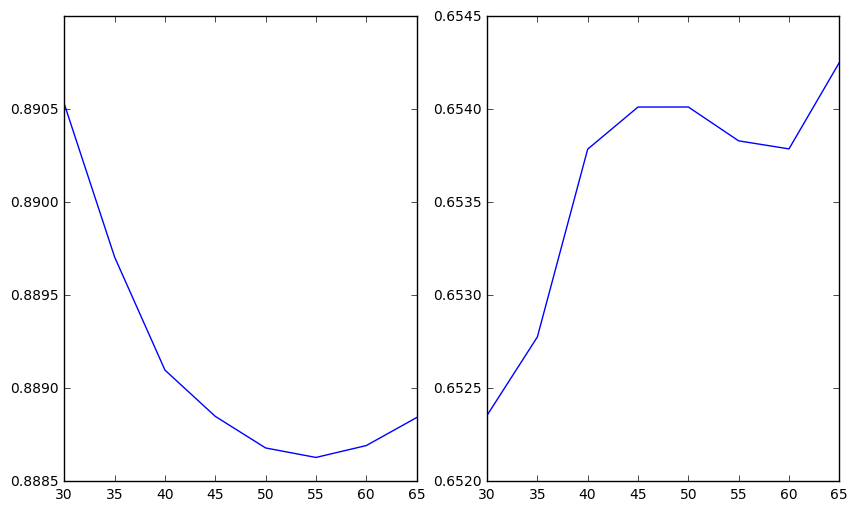

In [55]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot([kNNBaseline_GridSearch.cv_results['params'][i]['k'] for i in range(8)],
        [kNNBaseline_GridSearch.cv_results['scores'][i]['RMSE'] for i in range(8)])
plt.subplot(122)
plt.plot([kNNBaseline_GridSearch.cv_results['params'][i]['k'] for i in range(8)],
        [kNNBaseline_GridSearch.cv_results['scores'][i]['FCP'] for i in range(8)])

In [58]:
gr_KNNBaseline = KNNBaseline(k=kNNBaseline_GridSearch.best_params['rmse']['k'])

gr_KNNBaseline.train(surpriseTrain)


preds=[gr_KNNBaseline.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
preds_est = np.array([preds[i].est for i in range(len(preds))])
preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

errs = preds_true - preds_est
rmse = np.sqrt((errs**2).mean())
rmse

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


0.87933056319020175

In [ ]:
SVD_GridSearch = GridSearch(SVD, {'n_factors': [40,80], 'reg_all': [0.01,0.005], 'n_epochs':[200], 'lr_all': [0.001]}, measures=['rmse','fcp'])
SVD_GridSearch.evaluate(train_folds)

------------
Parameters combination 1 of 4
params:  {'lr_all': 0.001, 'reg_all': 0.01, 'n_factors': 40, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 0.9310
Mean FCP : 0.6961
------------
------------
Parameters combination 2 of 4
params:  {'lr_all': 0.001, 'reg_all': 0.01, 'n_factors': 80, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 0.9327
Mean FCP : 0.6965
------------
------------
Parameters combination 3 of 4
params:  {'lr_all': 0.001, 'reg_all': 0.005, 'n_factors': 40, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.

------------
Mean RMSE: 0.9316
Mean FCP : 0.6951
------------
------------
Parameters combination 4 of 4
params:  {'lr_all': 0.001, 'reg_all': 0.005, 'n_factors': 80, 'n_epochs': 200}
Evaluating RMSE, FCP of algorithm SVD.



In [ ]:
#[d1.update(SVD_GridSearch.param_combinations[i]) for i, d1 in enumerate(SVD_GridSearch.param_combinations)]
gl.SFrame({'reg_all': SVD_GridSearch.cv_results['reg_all'], 'n_factors': [d['n_factors'] for d in SVD_GridSearch.cv_results['params']],
         'RMSE': [s['RMSE'] for s in SVD_GridSearch.cv_results['scores']],
         'FCP': [s['FCP'] for s in SVD_GridSearch.cv_results['scores']]}).sort('RMSE')

In [103]:
gr_SVD = SVD(n_factors=80, reg_all=0.01, lr_all=0.001, n_epochs=200)

gr_SVD.train(surpriseTrain)


preds=[gr_SVD.predict(str(row['userID']),str(row['bookID']),row['rating']) for row in glRatingsTest]
preds_est = np.array([preds[i].est for i in range(len(preds))])
preds_true = np.array([preds[i].r_ui for i in range(len(preds))])

errs = preds_true - preds_est
rmse = np.sqrt((errs**2).mean())
rmse

0.92512127601718752

SOCIAL MODELS

In [23]:
glCommMeansTrain, glCommBookMeansTrain, commMeansTrain, commBookMeansTrain = \
makeSocialModelInputs(glRatingsTrainWithComm)

In [24]:
bootstrapRmsesFake = []

for bootstrapIndex in range(10):
    glRatingsTrainFakeComms = glRatingsTrain.copy()

    commUIDs = [uID for comm in allComms for uID in comm]
    fakeUserIndices = np.random.permutation(len(commUIDs))

    runningTotal = 0
    fakeComms = []
    for comm in allComms:
        fakeComms.append([commUIDs[index] for index in list(fakeUserIndices)[runningTotal:runningTotal+len(comm)]])
        runningTotal += len(comm)
    fakeCommDict = {uID: i for i, comm in enumerate(fakeComms) for uID in comm}
    glRatingsTrainFakeComms['comm'] = glRatingsTrainFakeComms['userID'].apply(lambda x: fakeCommDict[x])

    fakeGlCommMeansTrain, fakeGlCommBookMeansTrain, fakeCommMeansTrain, fakeCommBookMeansTrain = \
    makeSocialModelInputs(glRatingsTrainFakeComms)
    
    glRatingsTestFakeComms = glRatingsTest.copy()
    glRatingsTestFakeComms['comm'] = glRatingsTestFakeComms['userID'].apply(lambda x: fakeCommDict[x])
    
    rmsesFake = []

    for weight in meanWeights:
        rmsesFake.append(\
                    mixedPred(glRatingsTestFakeComms, \
                              fakeCommMeansTrain, fakeCommBookMeansTrain, fakeCommBookMeansTrain, rec_engine, rec_engine, \
                              numTrainRatings_Test,\
                              False, False, False, weight)[1])


    bootstrapRmsesFake.append(rmsesFake)
    #print [min(rmsesFake) < min(rmsesSimpleNoBookMeans) for rmsesFake in bootstrapRmsesFake]
trainSplitRmsesFake.append(bootstrapRmsesFake)

NameError: name 'meanWeights' is not defined

In [148]:
plt.hist(bootstrapRmsesFake - min(rmsesSimpleNoBookMeans))
print min(rmsesSimpleNoBookMeans)
np.mean(bootstrapRmsesFake)

NameError: name 'rmsesSimpleNoBookMeans' is not defined

In [25]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})
numTrainRatings_Test = np.array(glRatingsTestWithComm['userID'].apply(lambda x: numRatingsByUserDict[x]))

In [26]:
print len(trainSplitRmses)
print len(trainSplitRmsesFake)

NameError: name 'trainSplitRmses' is not defined

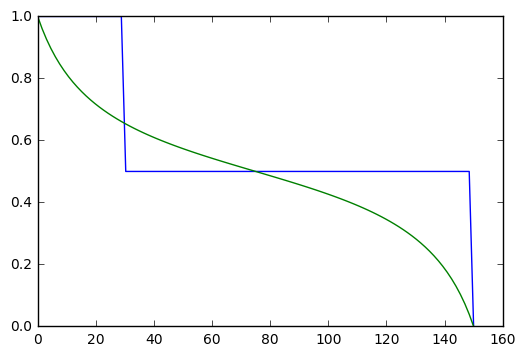

In [326]:
'''
adjWeights=(100. - np.linspace(0,100,100))/100.
adjWeights[adjWeights<0]=0
adjWeights = adjWeights**(0.5)
plt.plot(np.linspace(0,100,100), adjWeights)
'''
adjX = np.linspace(0,150,100)
adjWeights = 0.5*(adjX<30) + 0.5*(adjX < 150)
adjWeights2 = np.tan(-2.5*(adjX-75)/150)
adjWeights2 = adjWeights2 / (2*max(adjWeights2))
adjWeights2 = adjWeights2 - min(adjWeights2)
plt.plot(adjX, adjWeights)
plt.plot(adjX, adjWeights2)


In [27]:
rec_engine = surprisePredWrapper(gr_KNNBaseline)

meanWeights = np.linspace(0,0.5,20)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, True, weight)[1])


'''
#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test, \
                          False, False, False, weight)[1])

trainSplitRmses.append(rmsesSimpleNoBookMeans)
'''    
#SANITY CHECK
'''
rmsesFake = []

for weight in meanWeights:
    rmsesFake.append(\
                mixedPred(glRatingsTestFakeComms, \
                          fakeCommMeansTrain, fakeCommBookMeansTrain, fakeCommBookMeansTrain, rec_engine, rec_engine, \
                          numTrainRatings_Test,\
                          False, False, False, weight)[1])

#FACTORIZING COMM MEANS
rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8 \
                          commMeans_rec_engine_baseline, True, False, True, weight)[1])
'''

'\nrmsesFake = []\n\nfor weight in meanWeights:\n    rmsesFake.append(                mixedPred(glRatingsTestFakeComms,                           fakeCommMeansTrain, fakeCommBookMeansTrain, fakeCommBookMeansTrain, rec_engine, rec_engine,                           numTrainRatings_Test,                          False, False, False, weight)[1])\n\n#FACTORIZING COMM MEANS\nrmsesFac = []\nfor weight in meanWeights:\n    rmsesFac.append(                mixedPred(glRatingsTestWithComm,                           commMeansTrain, commBookMeansTrain, rec_engine_8, rec_engine_8                           commMeans_rec_engine_baseline, True, False, True, weight)[1])\n'

0.078947368421052627

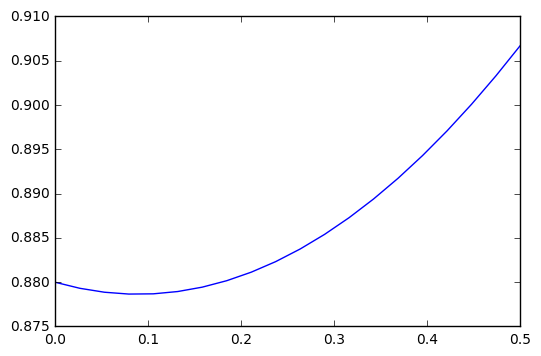

In [28]:
plt.plot(meanWeights, rmsesSimple)
optimalWeight = meanWeights[np.argmin(rmsesSimple)]
optimalWeight

In [ ]:
rmsesSocial = []

rec_engine_social = surprisePredWrapper()

for weight in meanWeights:
    rmsesSocial.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_social, \
                          numTrainRatings_Test, \
                          False, True, True, weight)[1])



In [350]:
optimalPreds = pd.Series(mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_baseline, \
                          numTrainRatings_Test, \
                          False, True, False, optimalWeight)[0])

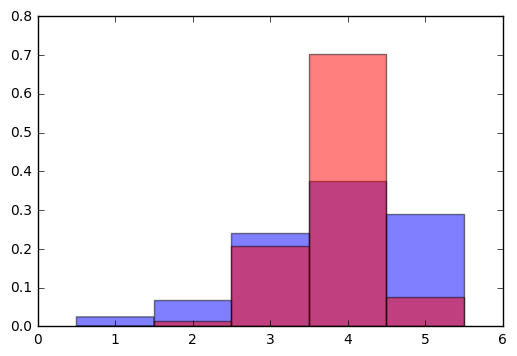

In [351]:
plt.hist(glRatingsTest['rating'],normed=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5],alpha=0.5);
plt.hist(optimalPreds,normed=True,bins=[0.5,1.5,2.5,3.5,4.5,5.5],alpha=0.5,color='r');

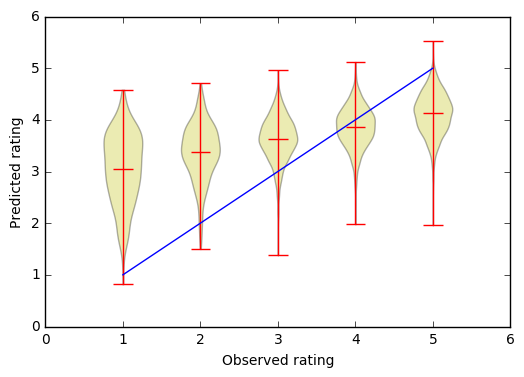

In [352]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(optimalPreds[pd.Series(glRatingsTestWithComm['rating'] == rating).astype(bool)]))

plt.violinplot(preds_by_rating, positions=rating_cats,showmeans=True);
plt.plot([1,5],[1,5])
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');

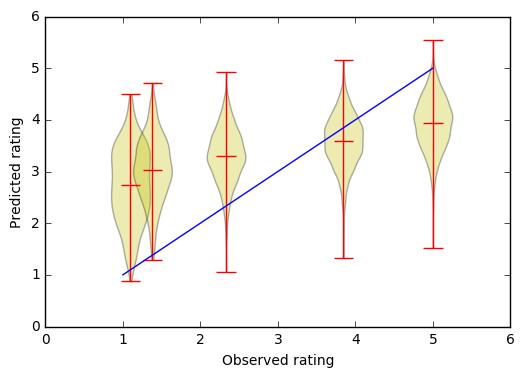

In [337]:
preds_by_rating = []
rating_cats = range(1,6)

interval_eps = 0.001;
transformed_rating_intervals = [(transformed_rating_dict[r] - 0.001, transformed_rating_dict[r] + 0.001)\
                                for r in rating_cats]

for rating in rating_cats:
    preds_by_rating.append(list(optimalPreds[pd.Series(glRatingsTestWithComm['rating'] == rating).astype(bool)]))

plt.violinplot(preds_by_rating, positions=[transformed_rating_dict[r] for r in rating_cats],showmeans=True);
plt.plot([min(transformed_rating_dict),max(transformed_rating_dict)],[min(transformed_rating_dict),max(transformed_rating_dict)])
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');

In [335]:
plt.violinplot?

[0.5, 5.5, 0.5, 5.5]

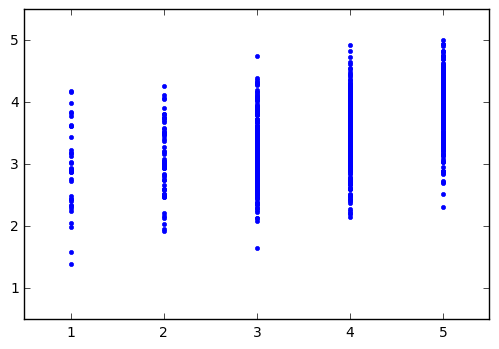

In [328]:
plt.plot(glRatingsTestWithComm['rating'][:1000],optimalPreds[:1000],'.',linewidth=0)
plt.axis([0.5, 5.5, 0.5, 5.5])

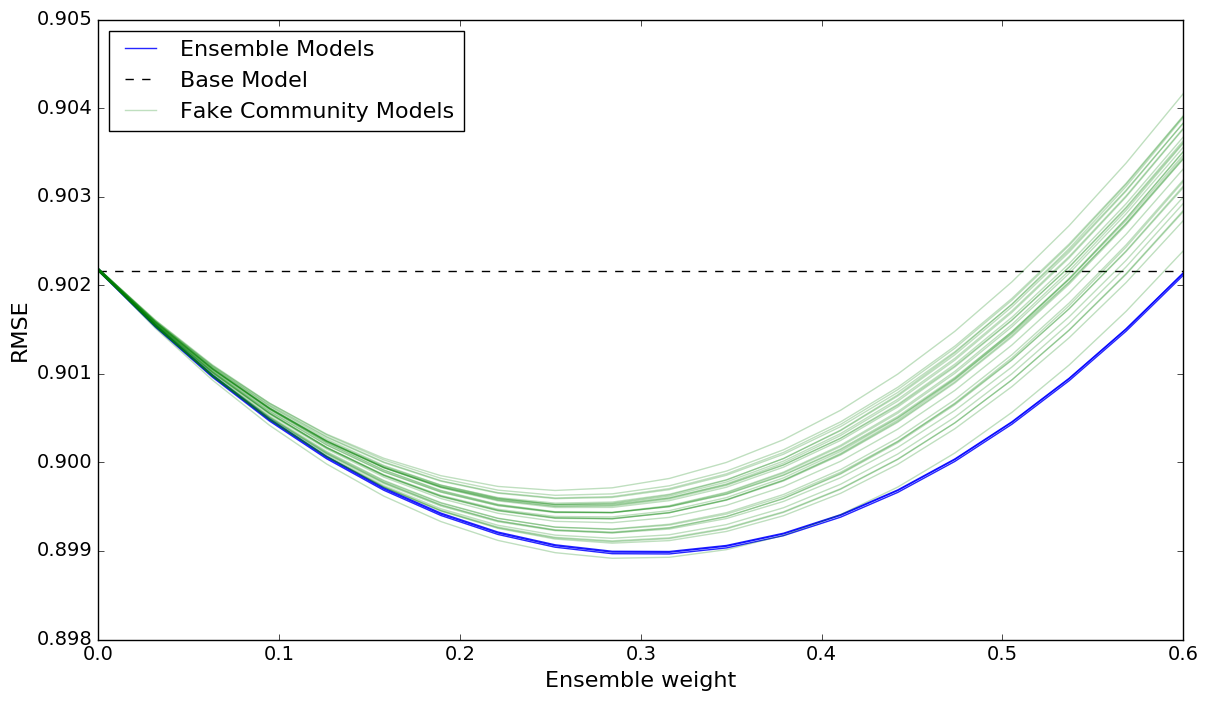

In [402]:
plt.figure(figsize=(14,8))

blueLabel = {0: 'Ensemble Models', 1: None, 2: None}
greenLabel = defaultdict(lambda: None,{0: 'Fake Community Models'})

for i, rmsesSimpleNoBookMeans in enumerate(trainSplitRmses):
    plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-', color='b', label=blueLabel[i], alpha=0.85);
#plt.plot(meanWeights, rmsesFake, '-', label='Sanity check');
plt.axhline(rmsesSimpleNoBookMeans[0],color='k',linestyle='--', label='Base Model');
#plt.axhline(rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)],linestyle='--',label='Best Combined Model')

for i, curve in enumerate([curve for bootstrapRmsesFake in trainSplitRmsesFake for curve in bootstrapRmsesFake]):
    plt.plot(meanWeights, curve, color='g', label=greenLabel[i], alpha=0.25)
#plt.axhline(np.mean(bootstrapRmsesFake),linestyle='--',color='g',label='Mean Sanity Check Model')

plt.xlabel('Ensemble weight',fontsize=16)
plt.ylabel('RMSE',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best',fontsize=16);

In [338]:
#print meanWeights[np.argmin(rmsesFake)]
#print rmsesFake[np.argmin(rmsesFake)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]


0.315789473684
0.898996257624


In [339]:
0.252631578947
0.898785990465
In [ ]:
In [ ]:
In [ ]:
In [ ]:


SyntaxError: invalid syntax (<ipython-input-339-95983e06353e>, line 3)

USING COMMUNITY MEANS OF RECOMMENDER PREDICTIONS

In [912]:
test = [(bookID, userID) for bookID, userID in product(glRatings['bookID'].unique(), glRatings['userID'].unique())]

In [913]:
#test
testDict = {}
npTest = np.array(test)
testDict['bookID'] = npTest[:,0]
testDict['userID'] = npTest[:,1]
sfTest = gl.SFrame(testDict)

In [914]:
allPreds = rec_engine.predict(sfTest)

In [915]:
sfTest.add_column(allPreds, 'preds')

bookID,userID,preds
1162543,32119,3.03590595132
1162543,271433,3.03590595132
1162543,135475,3.03590595132
1162543,5247,3.03590595132
1162543,14871,3.03590595132
1162543,247244,3.03590595132
1162543,147129,3.03590595132
1162543,9169100,3.03590595132
1162543,94664,3.03590595132
1162543,24243723,3.03590595132


In [916]:
commDict = {uID: i for i, comm in enumerate(allComms) for uID in comm}

sfTest.add_column(sfTest['userID'].apply(lambda x: commDict[int(x)]), 'comm')

bookID,userID,preds,comm
1162543,32119,3.03590595132,8
1162543,271433,3.03590595132,55
1162543,135475,3.03590595132,41
1162543,5247,3.03590595132,21
1162543,14871,3.03590595132,22
1162543,247244,3.03590595132,17
1162543,147129,3.03590595132,46
1162543,9169100,3.03590595132,68
1162543,94664,3.03590595132,30
1162543,24243723,3.03590595132,48


In [917]:
sfTest[['bookID', 'preds', 'comm']].groupby(['bookID', 'comm'], {'avgPreds': gl.aggregate.AVG('preds')})

bookID,comm,avgPreds
10569,55,4.00803316539
11278959,59,3.47377260929
28381,4,3.93346711403
17336704,24,3.63113679891
485894,49,3.94561145609
7937843,46,3.83564817315
29209,2,3.78459570525
420282,2,4.0451092661
216363,4,3.92858416741
11590,30,3.48331939583


In [918]:
factorCommBookMeansTrain = {}
for row in sfTest:
    factorCommBookMeansTrain[(row['bookID'], row['comm'])] = row['preds']


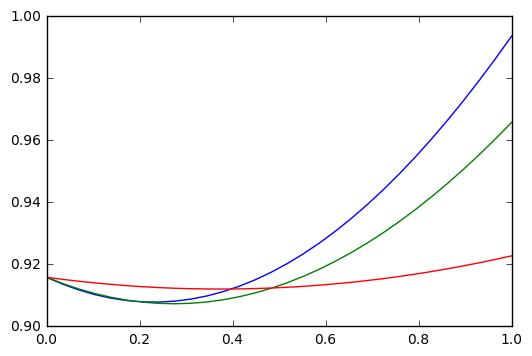

In [919]:
meanWeights = np.linspace(0,1,30)

#SIMPLE PREDICTION FROM COMM MEANS
rmsesSimple = []

for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
    
#FACTORIZING COMM MEANS

rmsesFac = []
for weight in meanWeights:
    rmsesFac.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine, \
                          True, False, True, weight)[1])

plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
plt.plot(meanWeights, rmsesFac, '-')

In [826]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

0.137931034483
0.887995003275


FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA

In [930]:
#glCommTrain = glRatingsTrainWithComm.copy()['bookID', 'comm', 'rating']
#glCommTest = glRatingsTestWithComm.copy()['bookID', 'comm', 'rating']
glCommTrain = glCommBookMeansTrain.copy()

glCommTrain['rating'] = glCommTrain['meanBookRatingByComm']
glCommTrain.remove_column('meanBookRatingByComm')

bookID,comm,rating
485894,49,3.0
7937843,46,2.5
5043,24,3.0
4407,30,3.0
6334,49,3.66666666667
2696,49,4.0
22328,3,5.0
2429135,46,3.25
2612,70,3.0
4953,23,3.5


In [931]:
glCommMeansTest, glCommBookMeansTest, commMeansTest, commBookMeansTest = \
makeSocialModelInputs(glRatingsTestWithComm)

glCommTest = glCommBookMeansTest.copy()
glCommTest['rating'] = glCommTest['meanBookRatingByComm']
glCommTest.remove_column('meanBookRatingByComm')

bookID,comm,rating
1971304,49,5.0
2429135,46,1.0
11,4,4.0
12220,55,5.0
249747,69,4.0
8520610,46,5.0
13335037,13,5.0
13256917,2,3.5
9361589,49,4.0
21,49,5.0


In [932]:
degreesOfFreedomStats(glCommTrain)

22220 observations
72 users
1270 books

A recommender with 0 factor(s) (plus linear terms) would use 6.0% of the degrees of freedom present in the data.
(16.6 observations per model degree of freedom)

A recommender with 1 factor(s) (plus linear terms) would use 12.1% of the degrees of freedom present in the data.
(8.3 observations per model degree of freedom)

A recommender with 2 factor(s) (plus linear terms) would use 18.1% of the degrees of freedom present in the data.
(5.5 observations per model degree of freedom)

A recommender with 3 factor(s) (plus linear terms) would use 24.2% of the degrees of freedom present in the data.
(4.1 observations per model degree of freedom)

A recommender with 4 factor(s) (plus linear terms) would use 30.2% of the degrees of freedom present in the data.
(3.3 observations per model degree of freedom)

A recommender with 5 factor(s) (plus linear terms) would use 36.2% of the degrees of freedom present in the data.
(2.8 observations per model degree o

In [939]:
rec_engine_comm_baseline = gl.factorization_recommender.create(   observation_data=glCommTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=0,
                                                    solver='auto',
                                                    max_iterations=50,
                                                    regularization = 1e-2,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 22220 observations with 72 users and 1270 items.

Data prepared in: 0.124427s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 0        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 22220 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.331056          | No Decrease (0.79202 >= 0.777007)        |

| 1       | 0.0827641         | 0.603607                                 |

| 2       | 0.041382          | 0.608211                                 |

| 3       | 0.020691          | 0.630366                                 |

| 4       | 0.0103455         | 0.656499                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0827641         | 0.603607                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 99us         | 0.76868           | 0.876744              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 660.22ms     | 0.784455          | 0.876689              | 0.0827641   |

| 2       | 1.32s        | 0.663837          | 0.805691              | 0.00426835  |

| 3       | 1.99s        | 0.642378          | 0.792447              | 0.00219066  |

| 4       | 2.65s        | 0.63687           | 0.789062              | 0.0014685   |

| 5       | 3.30s        | 0.634114          | 0.787374              | 0.00110721  |

| 6       | 3.95s        | 0.63222           | 0.786212              | 0.000888598 |

| 10      | 6.55s        | 0.628514          | 0.78394               | 0.000496483 |

| 11      | 7.23s        | 0.627972          | 0.783607              | 0.000447153 |

| 15      | 9.89s        | 0.626452          | 0.782673              | 0.000319983 |

| 20      | 13.19s       | 0.625307          | 0.781968              | 0.000236062 |

| 25      | 16.51s       | 0.624551          | 0.781502              | 0.000187015 |

| 30      | 19.80s       | 0.624005          | 0.781164              | 0.000154843 |

| 35      | 23.07s       | 0.623586          | 0.780904              | 0.000132115 |

| 40      | 26.39s       | 0.623249          | 0.780695              | 0.000115205 |

| 45      | 29.77s       | 0.622973          | 0.780523              | 0.000102133 |

| 50      | 33.09s       | 0.622739          | 0.780377              | 9.17249e-05 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.622501

Final training RMSE: 0.780225

In [940]:
rec_engine_comm_baseline.evaluate_rmse(glCommTest, target='rating')['rmse_overall']

0.8492236017877337

In [945]:
rec_engine_comm = gl.factorization_recommender.create(   observation_data=glCommTrain, 
                                                    user_id="comm", 
                                                    item_id="bookID", 
                                                    target='rating',
                                                    num_factors=4,
                                                    solver='auto',
                                                    max_iterations=50,
                                                    regularization = 1e-3,
                                                    linear_regularization = 1e-4
                                                    )

Recsys training: model = factorization_recommender

Preparing data set.

Data has 22220 observations with 72 users and 1270 items.

Data prepared in: 0.141546s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 4        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 0.0001   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 22220 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 3.31056           | 0.707354                                 |

| 1       | 1.65528           | 0.754305                                 |

| 2       | 0.827641          | Not Viable                               |

| 3       | 0.20691           | No Decrease (1.08416 >= 0.777007)        |

+---------+-------------------+------------------------------------------+

| Final   | 3.31056           | 0.707354                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 93us         | 0.76868           | 0.876744              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 461.388ms    | DIVERGED          | DIVERGED              | 3.31056     |

| RESET   | 512.836ms    | 0.768676          | 0.876742              |             |

| 1       | 1.22s        | DIVERGED          | DIVERGED              | 1.65528     |

| RESET   | 1.26s        | 0.768676          | 0.876742              |             |

| 1       | 1.98s        | DIVERGED          | DIVERGED              | 0.827641    |

| RESET   | 2.03s        | 0.768676          | 0.876742              |             |

| 1       | 2.71s        | DIVERGED          | DIVERGED              | 0.41382     |

| RESET   | 2.76s        | 0.768673          | 0.87674               |             |

| 1       | 3.43s        | DIVERGED          | DIVERGED              | 0.20691     |

| RESET   | 3.44s        | 0.768678          | 0.876743              |             |

| 1       | 4.17s        | DIVERGED          | DIVERGED              | 0.103455    |

| RESET   | 4.21s        | 0.76868           | 0.876744              |             |

| 1       | 4.86s        | 0.740041          | 0.853386              | 0.0517275   |

| 2       | 5.45s        | 0.666843          | 0.808914              | 0.0240662   |

| 3       | 6.10s        | 0.648065          | 0.79693               | 0.0156808   |

| 4       | 6.76s        | 0.640544          | 0.791955              | 0.011629    |

| 5       | 7.42s        | 0.635988          | 0.788959              | 0.00924111  |

| 6       | 8.06s        | 0.63309           | 0.786992              | 0.00766683  |

| 9       | 10.00s       | 0.627889          | 0.783522              | 0.00507377  |

| 11      | 11.29s       | 0.625847          | 0.782141              | 0.00414024  |

| 14      | 13.39s       | 0.624321          | 0.781089              | 0.00324473  |

| 19      | 16.75s       | 0.622531          | 0.779837              | 0.00238497  |

| 24      | 20.02s       | 0.621532          | 0.779142              | 0.0018854   |

| 29      | 23.35s       | 0.620829          | 0.778641              | 0.00155887  |

| 34      | 26.65s       | 0.620275          | 0.778248              | 0.00132874  |

| 39      | 29.89s       | 0.619893          | 0.77797               | 0.00113247  |

| 44      | 33.18s       | 0.619605          | 0.77776               | 0.000998562 |

| 49      | 36.54s       | 0.619406          | 0.777608              | 0.000898844 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached (hard limit).

Computing final objective value and training RMSE.

Final objective value: 0.617394

Final training RMSE: 0.776313

In [946]:
print rec_engine_comm.evaluate_rmse(glCommTest, target='rating')['rmse_overall']
print rec_engine_comm.evaluate_rmse(glCommTest, target='rating')['rmse_overall'] - rec_engine_comm_baseline.evaluate_rmse(glCommTest, target='rating')['rmse_overall']

0.84850909904
-0.00071450274821


In [ ]:
0.848510407994
-0.000713193794181
In [ ]:
In [ ]:
In [ ]:


In [947]:
rec_engine_comm.get('coefficients')['comm']

comm,linear_terms,factors
49,-0.0485175698996,"[0.00232555577531,0.00428900169209, ..."
46,-0.0348515696824,"[0.00304393609986,0.00289199361578, ..."
24,0.318906158209,"[0.000162804426509,0.000785160227679, ..."
30,0.135711625218,"[-5.40788641956e-05,0.00510933995247, ..."
3,0.0516358315945,"[-9.04402259039e-05,0.000493495434057, ..."
70,-0.257359296083,"[-0.00256620999426,0.00144182541408, ..."
23,-0.284745752811,"[0.000749856524635,0.000388702406781, ..."
59,0.31371113658,"[0.000384650717024,-0.000852791592479, ..."
60,-0.284195005894,"[0.00193695141934,0.000471268198453, ..."
71,-0.176614835858,"[-0.000641892198473,0.00163679639809, ..."


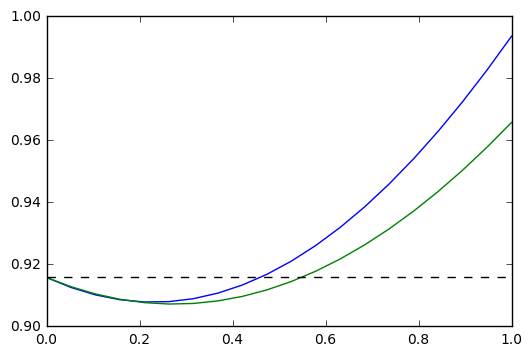

In [1009]:
meanWeights = np.linspace(0,1,20)

#SIMPLE PREDICTION FROM COMM MEANS

rmsesSimple = []
for weight in meanWeights:
    rmsesSimple.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, True, weight)[1])

#SIMPLE PREDICTION FROM COMM MEANS (no book means)
rmsesSimpleNoBookMeans = []

for weight in meanWeights:
    rmsesSimpleNoBookMeans.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                          False, False, False, weight)[1])
                          

#FACTORIZATION RECOMMENDER FOR RAW (COMMUNITY-BOOK-RATING) DATA
rmsesSocialRec = []

for weight in meanWeights:
    rmsesSocialRec.append(\
                mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, weight)[1])


plt.plot(meanWeights, rmsesSimple, '-');
plt.plot(meanWeights, rmsesSimpleNoBookMeans, '-');
#plt.plot(meanWeights, rmsesSocialRec, '-');


In [765]:

models = gl.toolkits.model_parameter_search.grid_search.create((glCommTrain, glCommTest),
                                                     gl.factorization_recommender.create,
                                                     {'user_id': 'comm',
                                                      'item_id': 'bookID',
                                                      'target': 'rating',
                                                      'num_factors': [8, 32],
                                                      'max_iterations': 1000,
                                                      'regularization': [1e-2, 1e-3, 1e-4, 1e-7],
                                                      'linear_regularization': 1e-4
                                                      },
                                                      perform_trial_run=False)
                                                      

[INFO] graphlab.deploy.job: Validating job.
[INFO] graphlab.deploy.map_job: Validation complete. Job: 'Model-Parameter-Search-Nov-28-2016-20-38-1500000' ready for execution
[INFO] graphlab.deploy.map_job: Job: 'Model-Parameter-Search-Nov-28-2016-20-38-1500000' scheduled.


In [949]:
models.get_status()
#models.get_results(wait=False).sort('validation_rmse')

{'Canceled': 0, 'Completed': 8, 'Failed': 0, 'Pending': 0, 'Running': 0}

In [989]:
print meanWeights[np.argmin(rmsesSimple)]
print rmsesSimple[np.argmin(rmsesSimple)]

print ''

print meanWeights[np.argmin(rmsesSimpleNoBookMeans)]
print rmsesSimpleNoBookMeans[np.argmin(rmsesSimpleNoBookMeans)]

print ''


print meanWeights[np.argmin(rmsesSocialRec)]
print rmsesSocialRec[np.argmin(rmsesSocialRec)]

0.210526315789
0.907890443148

0.263157894737
0.907227957204

0.315789473684
0.910720455053


In [990]:
bestWeightComm = meanWeights[np.argmin(rmsesSimpleNoBookMeans)]

predsComm = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, bestWeightComm)[0]

predsBase = mixedPred(glRatingsTestWithComm, \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, 0)[0]

In [1002]:
signTestFrame = glRatingsTestWithComm[['bookID','userID','comm','rating']].copy()
signTestFrame.add_column(gl.SArray(predsComm), 'predsComm')
signTestFrame.add_column(gl.SArray(predsBase), 'predsBase')

bookID,userID,comm,rating,predsComm,predsBase
6194,12436,72,5,4.05259808782,4.06019743686
13586707,12436,72,5,3.8606226668,3.79965936547
7331435,12436,72,5,3.71201353679,3.59797554618
18143977,12436,72,4,3.8606226668,3.79965936547
22034,1,31,5,4.3160943172,4.53024527079
4948,1,31,5,4.48917493162,4.76514039036
22318578,1,31,5,4.04929489689,4.16816034322
13526165,1,31,4,4.10272208422,4.24066866888
231850,1,31,5,4.42062762133,4.67211189782
31196,1,31,5,4.46873210819,4.73739655856


In [1003]:
errsBase = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsBase'])**2)
errsBase

errsComm = np.abs(np.array(signTestFrame['rating'] - signTestFrame['predsComm'])**2)
(errsComm < errsBase).mean()

0.50594362745098043

In [1004]:
signTestFrame.add_column(gl.SArray(errsComm), 'errsComm')
signTestFrame.add_column(gl.SArray(errsBase), 'errsBase')

bookID,userID,comm,rating,predsComm,predsBase,errsComm,errsBase
6194,12436,72,5,4.05259808782,4.06019743686,0.897570383195,0.883228857679
13586707,12436,72,5,3.8606226668,3.79965936547,1.29818070742,1.44081763891
7331435,12436,72,5,3.71201353679,3.59797554618,1.65890912941,1.96567256912
18143977,12436,72,4,3.8606226668,3.79965936547,0.0194260410108,0.0401363698442
22034,1,31,5,4.3160943172,4.53024527079,0.46772698296,0.220669505615
4948,1,31,5,4.48917493162,4.76514039036,0.260942250482,0.0551590362411
22318578,1,31,5,4.04929489689,4.16816034322,0.903840193075,0.691957214586
13526165,1,31,4,4.10272208422,4.24066866888,0.0105518265866,0.0579214081822
231850,1,31,5,4.42062762133,4.67211189782,0.335672353168,0.107510607554
31196,1,31,5,4.46873210819,4.73739655856,0.282245572864,0.0689605674552


In [1008]:
signTestFrame.groupby(['rating'], {'errsCommAvg': gl.aggregate.AVG('errsComm'),\
                                  'errsBaseAvg': gl.aggregate.AVG('errsBase')}).sort('rating')

rating,errsBaseAvg,errsCommAvg
1,5.90448534451,6.15340499184
2,2.6688149994,2.67606710604
3,0.655697848018,0.582972461962
4,0.169955042012,0.117052225647
5,1.18143082173,1.25054546585


In [993]:
roundedPredsBase = np.round(predsBase)
roundedPredsComm = np.round(predsComm)

In [994]:
(roundedPredsBase == signTestFrame['rating']).mean()

0.41200980392156861

In [995]:
(roundedPredsComm == signTestFrame['rating']).mean()

0.41409313725490199

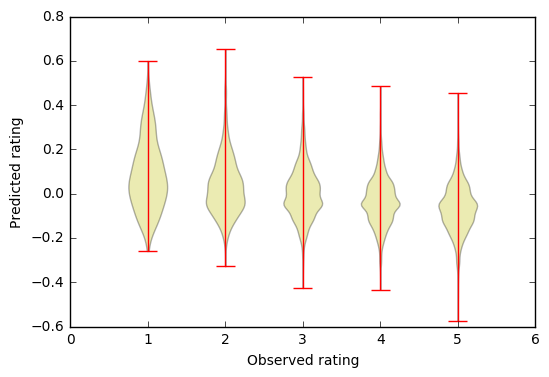

In [998]:
preds_by_rating = []
rating_cats = range(1,6)

for rating in rating_cats:
    preds_by_rating.append(list(predsComm[np.array(glRatingsTest['rating']) == rating]\
                          -predsBase[np.array(glRatingsTest['rating']) == rating]))

plt.violinplot(preds_by_rating, positions=rating_cats);
plt.xlabel('Observed rating');
plt.ylabel('Predicted rating');
#for rating in rating_cats:
#    plt.axhline(rating,linestyle='--',linewidth=1,alpha=0.5)

In [999]:
for i, category in enumerate(preds_by_rating):
    print (i+1, np.median(category))

(1, 0.058961325610539461)
(2, 0.019585672106249952)
(3, -0.0023628270171291987)
(4, -0.039621774063719251)
(5, -0.062194621033736741)


3.835876355697995

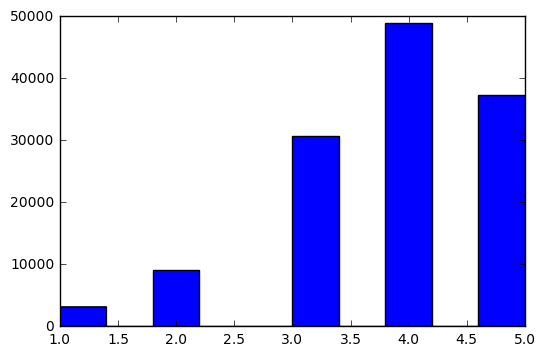

In [174]:
plt.hist(glRatingsTrain['rating'])
(glRatingsTrain['rating']).mean()

In [963]:
coef_dict = rec_engine.get('coefficients')

In [964]:
coef_dict['userID']

userID,linear_terms,factors
13389,0.449082821608,"[-2.9401418189e-08,-2.47457433034e-06, ..."
147129,0.018716853112,"[6.31890827663e-07,-1.23543497921e-06, ..."
82625,0.256159394979,"[1.29775025925e-06,1.10020755528e-06, ..."
12251,0.671747028828,"[-1.14628380743e-06,-3.97139643837e-07, ..."
160216,0.0298878327012,"[5.05336538481e-06,7.61476530897e-06, ..."
1,0.368342787027,"[-3.67200627807e-05,5.10490754095e-05, ..."
546,0.484111756086,"[-2.40624467551e-06,-3.51996568497e-05, ..."
609,-0.215856999159,"[-2.25407035259e-07,8.75285149959e-06, ..."
657,0.242997214198,"[3.48835055775e-06,1.58360251135e-06, ..."
25943,-0.445351481438,"[1.295065249e-05,-2.90351563308e-05, ..."


In [881]:
s = set(glRatings['bookID'].unique())
numCommsByBook = {k: len(v) for k, v in booksToRaterComms.items() if str(k) in s}

In [882]:
[(k, v) for k, v in numCommsByBook.items() if v == 40]

[(6310, 40),
 (49041, 40),
 (7445, 40),
 (6514, 40),
 (4473, 40),
 (37415, 40),
 (62291, 40),
 (11275, 40),
 (7588, 40),
 (1622, 40)]

In [892]:
for bID in [k for k, v in numCommsByBook.items() if v  == 50]:
    print bID
    print bookTitle(bID)

2429135
(u'The Girl with the Dragon Tattoo\n      \n          (Millennium #1)', 1766752)
48855
(u'The Diary of a Young Girl', 1900271)
168668
(u'Catch-22\n      \n          (Catch-22 #1)', 540094)
13496
(u'A Game of Thrones\n      \n          (A Song of Ice and Fire #1)', 1300530)
41865
(u'Twilight\n      \n          (Twilight  #1)', 3635695)
43641
(u'Water for Elephants', 1044043)
3985
(u'The Amazing Adventures of Kavalier & Clay', 147815)


In [894]:
testBID = 2429135

commIndices = []
allCommBookRatings = []
numRaters = []
meanRatings = []
earliestTimes = []

uIDsInGL = set(glRatings['userID'].unique())

for commIndex in booksToRaterComms[testBID]:
    commRatings = ratingsFull.find({'userID': {'$in': list(set(allComms[commIndex]) & uIDsInGL)}})
    commBookRatings = [(r['ratings'][str(testBID)][0], \
                        datetime.strptime(r['ratings'][str(testBID)][2], grDateFormat), \
                        r['userID'])\
                       for r in commRatings if str(testBID) in r['ratings'].keys()]
    allCommBookRatings.append(commBookRatings)
    
    commIndices.append(commIndex)
    numRaters.append(len(commBookRatings))
    meanRatings.append(np.mean(np.array(commBookRatings)[:,0]))
    earliestTimes.append(min(r[1] for r in commBookRatings))

timeOrder = np.argsort(earliestTimes)

numRatersCumSum = 0
for i in timeOrder:
    numRatersCumSum += numRaters[i]
    if numRaters[i] > 3:
        print 'Community %d' % commIndices[i]
        print '%d raters' % numRaters[i]
        print '%.1f mean rating' % meanRatings[i]
        print 'Earliest rating on %s' % datetime.strftime(earliestTimes[i], grDateFormat)
        print '\nTotal raters thus far: %d\n' % numRatersCumSum

Community 46
5 raters
2.8 mean rating
Earliest rating on Sep 25, 2008

Total raters thus far: 5

Community 10
14 raters
3.4 mean rating
Earliest rating on Nov 17, 2008

Total raters thus far: 22

Community 70
4 raters
4.0 mean rating
Earliest rating on Jan 23, 2009

Total raters thus far: 26

Community 65
12 raters
3.7 mean rating
Earliest rating on Apr 11, 2009

Total raters thus far: 41

Community 21
7 raters
3.4 mean rating
Earliest rating on Jul 15, 2009

Total raters thus far: 50

Community 33
8 raters
3.0 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 58

Community 23
6 raters
3.2 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 64

Community 49
9 raters
3.6 mean rating
Earliest rating on Aug 05, 2009

Total raters thus far: 73

Community 68
13 raters
3.7 mean rating
Earliest rating on Aug 28, 2009

Total raters thus far: 86

Community 17
4 raters
2.5 mean rating
Earliest rating on Sep 23, 2009

Total raters thus far: 90

Community 67
4 rat

In [103]:
relevantGLratings = glRatings[glRatings.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.print_rows(num_rows=42)

+--------+------+--------+----------+
| bookID | comm | rating |  userID  |
+--------+------+--------+----------+
| 11275  |  48  |   4    | 5455905  |
| 11275  |  48  |   4    | 8943786  |
| 11275  |  48  |   3    | 19569261 |
| 11275  |  48  |   4    | 8864511  |
| 11275  |  48  |   4    | 23434392 |
| 11275  |  48  |   5    | 9069989  |
| 11275  |  48  |   5    | 48801419 |
| 11275  |  48  |   4    | 8068801  |
| 11275  |  48  |   4    | 7551020  |
| 11275  |  48  |   5    | 2392247  |
| 11275  |  48  |   4    | 6512932  |
| 11275  |  48  |   3    | 5011787  |
| 11275  |  48  |   4    | 5724539  |
| 11275  |  48  |   5    | 40547054 |
| 11275  |  48  |   1    | 9136579  |
| 11275  |  48  |   5    | 20931024 |
| 11275  |  48  |   4    | 8481252  |
| 11275  |  48  |   5    | 25218011 |
| 11275  |  48  |   4    | 6308393  |
| 11275  |  48  |   5    | 20187777 |
| 11275  |  48  |   5    | 43756219 |
| 11275  |  48  |   3    | 26363295 |
| 11275  |  48  |   4    | 7756517  |
| 11275  |  

In [124]:
relevantGLratings = signTestFrame[signTestFrame.apply(lambda x: x['comm'] == 48 and x['bookID'] == str(testBID))]
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsBase']))), \
                             'errsBase')
relevantGLratings.add_column(gl.SArray(\
                             np.abs(np.array(relevantGLratings['rating'] - relevantGLratings['predsComm']))), \
                             'errsComm')

#relevantGLratings.print_rows(num_rows=42, num_columns=8)
print relevantGLratings['errsBase'].mean()
print relevantGLratings['errsComm'].mean()

0.607146395116
0.592260112867


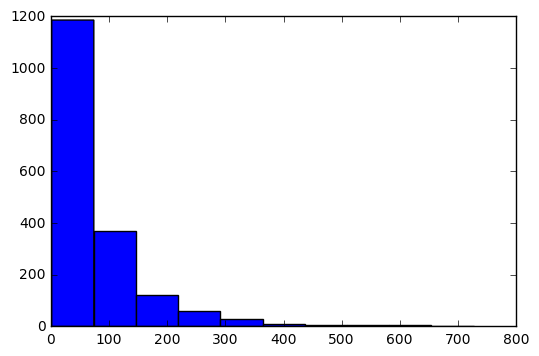

In [173]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByUser['numRatings']);

In [46]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [47]:
numRatingsByUser = glRatingsTrain.groupby(['userID'], {'numRatings': gl.aggregate.COUNT('rating')})
numRatingsByUserDict = defaultdict(int, {r['userID']: r['numRatings'] for r in numRatingsByUser})

In [48]:
pdRatingsTest['numRatingsByUser'] = pdRatingsTest['userID'].apply(lambda x: numRatingsByUserDict[x])

In [49]:
pdRatingsTest['numRatingsByUser'].describe()

count    11464.000000
mean        86.299285
std         65.267275
min          0.000000
25%         40.000000
50%         69.000000
75%        109.000000
max        349.000000
Name: numRatingsByUser, dtype: float64

In [235]:
numRatingsCutoffHigh = 100000
numRatingsCutoffLow = 150
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)]
print ((pdRatingsTest['numRatingsByUser'] > numRatingsCutoffLow) & (pdRatingsTest['numRatingsByUser'] < numRatingsCutoffHigh)).mean()

0.14017794836


In [236]:
'''
predsBase2 = mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, 0)[0]
1 - (np.abs(3.8 - predsBase2) / np.max(np.abs(3.8 - predsBase2)))
'''

"\npredsBase2 = mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]),                           commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm,                           False, True, False, 0)[0]\n1 - (np.abs(3.8 - predsBase2) / np.max(np.abs(3.8 - predsBase2)))\n"

In [237]:
meanWeights = np.linspace(0,0.6,60)

rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, commBookMeansTrain, rec_engine, rec_engine, \
                                            numTrainRatings_Test, \
                        False, False, False, weight)[1])
'''
rmsesFacManyRatings = []
for weight in meanWeights:
    rmsesFacManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, weight)[1])
'''

"\nrmsesFacManyRatings = []\nfor weight in meanWeights:\n    rmsesFacManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]),                           commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm,                           False, True, False, weight)[1])\n"

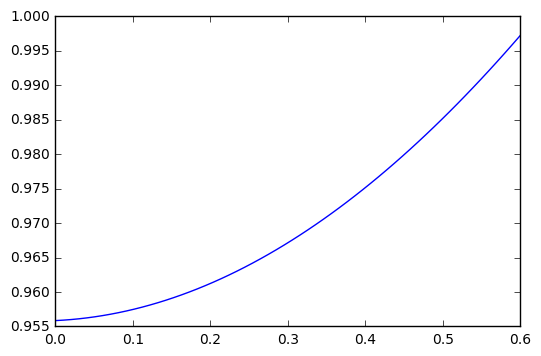

In [238]:
#plt.plot(meanWeights, rmsesSimpleNoBookMeans)
plt.plot(meanWeights, rmsesSimpleManyRatings)

#plt.plot(meanWeights, rmsesFacManyRatings)

In [239]:
print meanWeights[np.argmin(rmsesSimpleManyRatings)]
print rmsesSimpleManyRatings[np.argmin(rmsesSimpleManyRatings)]

0.0
0.955848817733


In [ ]:
[150, inf]: 0.0
[100, 150]: 0.11186440678
[70, 100]: 0.142372881356
[50, 70]: 0.122033898305
[30, 50]: 0.152542372881
[0, 30]: 0.264406779661

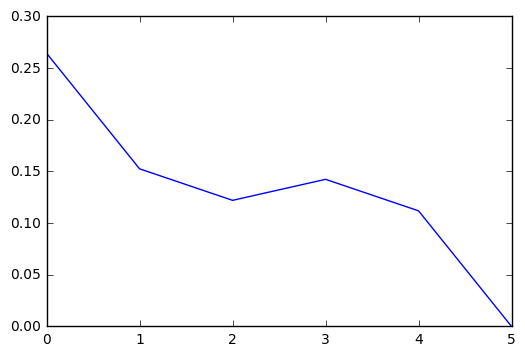

In [240]:
plt.plot([0.264406779661, 0.152542372881, 0.122033898305, 0.142372881356, 0.11186440678, 0])

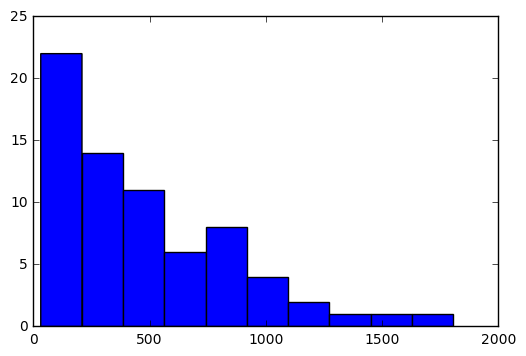

In [636]:
numRatingsByComm = glRatingsTrainWithComm.groupby(['comm'], {'numRatings': gl.aggregate.COUNT('rating')})
plt.hist(numRatingsByComm['numRatings']);

In [637]:
pdRatingsTrain = glRatingsTrainWithComm.to_dataframe()
pdRatingsTest = glRatingsTestWithComm.to_dataframe()

In [639]:
numRatingsByCommDict = defaultdict(int, {r['comm']: r['numRatings'] for r in numRatingsByComm})

In [640]:
pdRatingsTest['numRatingsByComm'] = pdRatingsTest['comm'].apply(lambda x: numRatingsByCommDict[x])

In [641]:
pdRatingsTest['numRatingsByComm'].describe()

count    15168.000000
mean       767.916930
std        472.438757
min          0.000000
25%        400.000000
50%        751.000000
75%       1180.000000
max       1806.000000
Name: numRatingsByComm, dtype: float64

In [657]:
numRatingsCutoff = 1180
pdManyRatings = pdRatingsTest[(pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) & (pdRatingsTest['numRatingsByComm'] > 0)]
print ((pdRatingsTest['numRatingsByComm'] > numRatingsCutoff) * (pdRatingsTest['numRatingsByComm'] > 0)).mean()

0.165545886076


In [658]:
pdManyRatings.shape

(2511, 5)

In [659]:
meanWeights = np.linspace(0,1,30)

rmsesSimpleManyRatings = []
for weight in meanWeights:
    rmsesSimpleManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, False, False, weight)[1])
    
rmsesFacManyRatings = []
for weight in meanWeights:
    rmsesFacManyRatings.append(mixedPred(gl.SFrame(pdManyRatings[['userID','bookID','comm','rating']]), \
                          commMeansTrain, commBookMeansTrain, factorCommBookMeansTrain, rec_engine, rec_engine_comm, \
                          False, True, False, weight)[1])

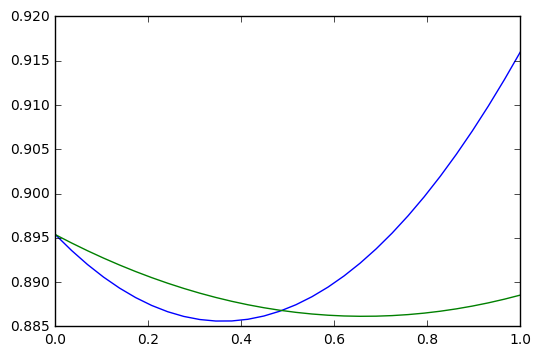

In [660]:
plt.plot(meanWeights, rmsesSimpleManyRatings)
plt.plot(meanWeights, rmsesFacManyRatings)

In [661]:
print meanWeights[np.argmin(rmsesSimpleManyRatings)]
print rmsesSimpleManyRatings[np.argmin(rmsesSimpleManyRatings)]

0.344827586207
0.885610939914


In [ ]:
0.448275862069
0.945779144527
In [ ]:
In [ ]:
In [ ]:
In [ ]:
In [ ]:
